### **Curating Tcel13290869**

Article:   Immune microniches shape intestinal Treg function

DOI: https://doi.org/10.1038/s41586-024-07251-0

Data Source :  https://treg-gut-niches.cellgeni.sanger.ac.uk/

##### **Packages required for curation**

In [1]:
#Import all packages required for curation

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from tqdm import tqdm
from scipy import sparse
from scipy.sparse import csr_matrix
import anndata as ad
import os
import subprocess
import math
import squidpy as sq
from PIL import Image
from pyometiff import OMETIFFReader

### **Curation Schema**

##### **X (Matrix Layers)**

##### **AnnData object**

In [3]:
# Load the AnnData object

In [4]:
folder = '/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/Treg_Gut_Niches/Data/spaceranger200_count_46450_Mus_Tcel13290869_mm10-2020-A/'

#REQUIRED to include background spots, so specify raw_feature_bc_matrix.h5
adata = sq.read.visium(folder, counts_file='raw_feature_bc_matrix.h5')


/nfs/users/nfs_s/sa32/anaconda/envs/shibla_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/users/nfs_s/sa32/anaconda/envs/shibla_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 4992 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
# Check if adata.X is a sparse matrix
if scipy.sparse.issparse(adata.X):
    # For sparse matrices, use the count_nonzero method of sparse matrices
    non_zero_counts = adata.X.getnnz(axis=1)
else:
    # For dense matrices, use np.count_nonzero
    non_zero_counts = np.count_nonzero(adata.X, axis=1)

# Filter observations based on the condition 'in_tissue' == 1
non_zero_counts_in_tissue = non_zero_counts[adata.obs['in_tissue'] == 1]

# Add this information to adata.obs
adata.obs['non_zero_counts'] = non_zero_counts

# Check for any zero values
any_zero_values = (non_zero_counts_in_tissue == 0).any()

if any_zero_values:
    print("There are zero values in 'non_zero_counts' for observations in tissue.")
else:
    print("There are no zero values in 'non_zero_counts' for observations in tissue.")

# Count the number of zero values
num_zero_values = (non_zero_counts_in_tissue == 0).sum()
num_zero_values


There are no zero values in 'non_zero_counts' for observations in tissue.


0

In [7]:
all_zero_rows = np.asarray(adata.X.sum(axis=1)).flatten() == 0
all_zero_cells_indices = np.where(all_zero_rows)[0]
all_zero_cells = adata[all_zero_cells_indices]
in_tissue_all_zero_cells = all_zero_cells[all_zero_cells.obs['in_tissue'] == 1]
print("Cell names of identified all-zero cells:")
print(all_zero_cells.obs.index.tolist())

Cell names of identified all-zero cells:
[]


In [8]:
import pandas as pd

# Ensure the 'array_col' column exists in adata.obs
if 'array_row' in adata.obs:
    # Find the indices where the values in 'array_col' are NaN
    nan_indices = adata.obs[pd.isna(adata.obs['array_row'])].index
    print("Indices with NaN values in 'array_row':", nan_indices.tolist())
else:
    print("The 'array_col' column does not exist in adata.obs")


Indices with NaN values in 'array_row': ['ACGCCTGACACGCGCT-1']


In [9]:
if 'array_col' in adata.obs:
    adata.obs['array_col'] = adata.obs['array_col'].fillna(0)
    print("NaN values in 'array_col' have been replaced with 0.")
else:
    print("The 'array_col' column does not exist in adata.obs")

NaN values in 'array_col' have been replaced with 0.


In [10]:
if 'array_row' in adata.obs:
    adata.obs['array_col'] = adata.obs['array_row'].fillna(0)
    print("NaN values in 'array_row have been replaced with 0.")
else:
    print("The 'array_row' column does not exist in adata.obs")

NaN values in 'array_row have been replaced with 0.


In [11]:
if 'in_tissue' in adata.obs:
    adata.obs['in_tissue'] = adata.obs['in_tissue'].fillna(0)
    print("NaN values in 'in_tissue have been replaced with 0.")
else:
    print("The 'in_tissue' column does not exist in adata.obs")

NaN values in 'in_tissue have been replaced with 0.


In [12]:
#SpaceRanger will not output spots that have zero reads mapped, so fill those in with 0s, if needed
if adata.obs.shape[0] < 4992:
    all_barcodes = pd.read_csv(folder + 'spatial/tissue_positions.csv', header=None)
    missing_barcodes = all_barcodes[all_barcodes[0].isin(list(adata.obs.index)) == False]
    missing_barcodes.set_index(0, inplace=True)
    missing_barcodes.rename(columns={1: 'in_tissue', 2:'array_row', 3:'array_col'}, inplace=True)
    empty_matrix = sparse.csr_matrix((missing_barcodes.shape[0], adata.var.shape[0]))
    missing_adata = ad.AnnData(empty_matrix, var=adata.var, obs=missing_barcodes[['in_tissue','array_row','array_col']])
    comb_adata = ad.concat([adata, missing_adata], uns_merge='first', merge='first')
    comb_adata.obsm['spatial'] = np.concatenate((adata.obsm['spatial'],missing_barcodes[[5,4]].values))
    adata = comb_adata

In [13]:
adata

AnnData object with n_obs × n_vars = 4992 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'non_zero_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

##### **X- expression matrix**

In [14]:
adata.X

<4992x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 21402311 stored elements in Compressed Sparse Row format>

In [15]:
print(adata.X)

  (0, 63)	1.0
  (0, 118)	1.0
  (0, 193)	1.0
  (0, 198)	1.0
  (0, 234)	1.0
  (0, 257)	1.0
  (0, 296)	1.0
  (0, 446)	1.0
  (0, 504)	2.0
  (0, 521)	2.0
  (0, 537)	1.0
  (0, 542)	1.0
  (0, 580)	1.0
  (0, 585)	1.0
  (0, 696)	1.0
  (0, 819)	1.0
  (0, 934)	1.0
  (0, 1008)	1.0
  (0, 1065)	1.0
  (0, 1177)	1.0
  (0, 1217)	1.0
  (0, 1311)	1.0
  (0, 1322)	1.0
  (0, 1329)	1.0
  (0, 1425)	1.0
  :	:
  (4991, 30754)	1.0
  (4991, 30853)	2.0
  (4991, 30854)	1.0
  (4991, 30859)	2.0
  (4991, 30873)	1.0
  (4991, 30875)	1.0
  (4991, 30878)	1.0
  (4991, 30974)	1.0
  (4991, 30991)	1.0
  (4991, 31032)	1.0
  (4991, 31080)	5.0
  (4991, 31083)	1.0
  (4991, 31186)	1.0
  (4991, 31191)	1.0
  (4991, 31271)	1.0
  (4991, 31440)	1.0
  (4991, 31450)	10.0
  (4991, 32196)	3.0
  (4991, 32197)	12.0
  (4991, 32198)	7.0
  (4991, 32200)	14.0
  (4991, 32201)	25.0
  (4991, 32202)	1.0
  (4991, 32204)	2.0
  (4991, 32207)	2.0


##### **Variables(var)**

In [16]:
adata.var

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,mm10
Gm1992,ENSMUSG00000089699,Gene Expression,mm10
Gm19938,ENSMUSG00000102331,Gene Expression,mm10
Gm37381,ENSMUSG00000102343,Gene Expression,mm10
Rp1,ENSMUSG00000025900,Gene Expression,mm10
...,...,...,...
AC124606.1,ENSMUSG00000095523,Gene Expression,mm10
AC133095.2,ENSMUSG00000095475,Gene Expression,mm10
AC133095.1,ENSMUSG00000094855,Gene Expression,mm10
AC234645.1,ENSMUSG00000095019,Gene Expression,mm10


In [17]:
adata.var.set_index('gene_ids', inplace=True)

In [18]:
adata.var

,feature_types,genome
gene_ids,,
ENSMUSG00000051951,Gene Expression,mm10
ENSMUSG00000089699,Gene Expression,mm10
ENSMUSG00000102331,Gene Expression,mm10
ENSMUSG00000102343,Gene Expression,mm10
ENSMUSG00000025900,Gene Expression,mm10
...,...,...
ENSMUSG00000095523,Gene Expression,mm10
ENSMUSG00000095475,Gene Expression,mm10
ENSMUSG00000094855,Gene Expression,mm10


In [19]:
approved_genes = pd.read_csv('/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/Endometrium_reference_integrated_atlas/genes_approved.csv')

In [20]:
genedict = {key: 1 for key in list(approved_genes.feature_id)}

In [21]:
var_to_keep_adata = [x for x in adata.var_names if (x in genedict)]

In [22]:
adata = adata[:, var_to_keep_adata].copy()

In [23]:
adata.var['feature_is_filtered'] = [False] * len(adata.var)

In [24]:
adata.var

,feature_types,genome,feature_is_filtered
gene_ids,,,
ENSMUSG00000051951,Gene Expression,mm10,False
ENSMUSG00000089699,Gene Expression,mm10,False
ENSMUSG00000102331,Gene Expression,mm10,False
ENSMUSG00000102343,Gene Expression,mm10,False
ENSMUSG00000025900,Gene Expression,mm10,False
...,...,...,...
ENSMUSG00000095523,Gene Expression,mm10,False
ENSMUSG00000095475,Gene Expression,mm10,False
ENSMUSG00000094855,Gene Expression,mm10,False


In [25]:
del adata.var['feature_types']
del adata.var['genome']

In [26]:
adata.var

,feature_is_filtered
gene_ids,
ENSMUSG00000051951,False
ENSMUSG00000089699,False
ENSMUSG00000102331,False
ENSMUSG00000102343,False
ENSMUSG00000025900,False
...,...
ENSMUSG00000095523,False
ENSMUSG00000095475,False
ENSMUSG00000094855,False


#### **Observations(obs) (Cell metadata)**

In [27]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts
AAACAACGAATAGTTC-1,0.0,0.0,0.0,502
AAACAAGTATCTCCCA-1,1.0,50.0,50.0,5479
AAACAATCTACTAGCA-1,0.0,3.0,3.0,1137
AAACACCAATAACTGC-1,1.0,59.0,59.0,7597
AAACAGAGCGACTCCT-1,1.0,14.0,14.0,7610
...,...,...,...,...
TTGTTTCACATCCAGG-1,1.0,58.0,58.0,4820
TTGTTTCATTAGTCTA-1,1.0,60.0,60.0,5928
TTGTTTCCATACAACT-1,1.0,45.0,45.0,5305
TTGTTTGTATTACACG-1,1.0,73.0,73.0,4907


#### **assay_ontology_term_id**

In [28]:
adata.obs['assay_ontology_term_id'] = 'EFO:0010961'

In [29]:
adata.obs['assay_ontology_term_id'] = adata.obs['assay_ontology_term_id'].astype('category')

#### **cell_type_ontology_term_id**

In [30]:
adata1 = sc.read_h5ad('/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/Treg_Gut_Niches/Final_objects/Tcel13290869_download.h5ad')

In [31]:
adata1.obs

,in_tissue,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,donor_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id
spot_id,,,,,,,,,,,,,,,,,,,,,
Mus_Tcel13290869_AAACAAGTATCTCCCA-1,1.0,3B_Hh.anti_IL10r,5479,8.608860,23726.0,10.074368,24.121218,33.553905,44.900108,58.893196,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
Mus_Tcel13290869_AAACACCAATAACTGC-1,1.0,3B_Hh.anti_IL10r,7597,8.935640,46612.0,10.749635,24.343517,36.254612,47.775249,60.306358,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
Mus_Tcel13290869_AAACAGAGCGACTCCT-1,1.0,3B_Hh.anti_IL10r,7610,8.937350,44794.0,10.709852,20.402287,30.309862,42.871815,57.295620,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
Mus_Tcel13290869_AAACAGCTTTCAGAAG-1,1.0,3B_Hh.anti_IL10r,4206,8.344505,18791.0,9.841187,27.130009,36.820820,48.475334,64.429779,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
Mus_Tcel13290869_AAACAGGGTCTATATT-1,1.0,3B_Hh.anti_IL10r,6782,8.822175,33615.0,10.422757,17.852150,27.434181,39.526997,54.431057,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mus_Tcel13290869_TTGTTCTAGATACGCT-1,1.0,3B_Hh.anti_IL10r,3728,8.223895,14173.0,9.559165,26.677485,36.484867,48.761730,64.185425,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
Mus_Tcel13290869_TTGTTGTGTGTCAAGA-1,1.0,3B_Hh.anti_IL10r,5942,8.689969,30684.0,10.331530,25.078217,34.731457,46.597576,60.513622,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
Mus_Tcel13290869_TTGTTTCACATCCAGG-1,1.0,3B_Hh.anti_IL10r,4820,8.480737,18295.0,9.814438,22.886034,34.370045,46.264008,60.054661,...,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155


In [32]:
adata1.obs.columns

Index(['in_tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes',
       ...
       'donor_id', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'sex_ontology_term_id', 'suspension_type', 'tissue_type',
       'tissue_ontology_term_id'],
      dtype='object', length=101)

In [33]:
adata1.obs['barcodes'] = adata1.obs_names
adata1.obs['barcodes'] = adata1.obs['barcodes'].str.extract(r'([ATGC]{10,16})', expand=False)

In [34]:
adata1.obs

,in_tissue,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id,barcodes
spot_id,,,,,,,,,,,,,,,,,,,,,
Mus_Tcel13290869_AAACAAGTATCTCCCA-1,1.0,3B_Hh.anti_IL10r,5479,8.608860,23726.0,10.074368,24.121218,33.553905,44.900108,58.893196,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,AAACAAGTATCTCCCA
Mus_Tcel13290869_AAACACCAATAACTGC-1,1.0,3B_Hh.anti_IL10r,7597,8.935640,46612.0,10.749635,24.343517,36.254612,47.775249,60.306358,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,AAACACCAATAACTGC
Mus_Tcel13290869_AAACAGAGCGACTCCT-1,1.0,3B_Hh.anti_IL10r,7610,8.937350,44794.0,10.709852,20.402287,30.309862,42.871815,57.295620,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,AAACAGAGCGACTCCT
Mus_Tcel13290869_AAACAGCTTTCAGAAG-1,1.0,3B_Hh.anti_IL10r,4206,8.344505,18791.0,9.841187,27.130009,36.820820,48.475334,64.429779,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,AAACAGCTTTCAGAAG
Mus_Tcel13290869_AAACAGGGTCTATATT-1,1.0,3B_Hh.anti_IL10r,6782,8.822175,33615.0,10.422757,17.852150,27.434181,39.526997,54.431057,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,AAACAGGGTCTATATT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mus_Tcel13290869_TTGTTCTAGATACGCT-1,1.0,3B_Hh.anti_IL10r,3728,8.223895,14173.0,9.559165,26.677485,36.484867,48.761730,64.185425,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,TTGTTCTAGATACGCT
Mus_Tcel13290869_TTGTTGTGTGTCAAGA-1,1.0,3B_Hh.anti_IL10r,5942,8.689969,30684.0,10.331530,25.078217,34.731457,46.597576,60.513622,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,TTGTTGTGTGTCAAGA
Mus_Tcel13290869_TTGTTTCACATCCAGG-1,1.0,3B_Hh.anti_IL10r,4820,8.480737,18295.0,9.814438,22.886034,34.370045,46.264008,60.054661,...,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155,TTGTTTCACATCCAGG


In [35]:
# Ensure 'barcode' and 'cell_type_ontology_term_id' are columns in adata.obs
if 'barcodes' in adata1.obs.columns and 'cell_type_ontology_term_id' in adata1.obs.columns:
    # Create the dictionary
    mapping = dict(zip(adata1.obs['barcodes'], adata1.obs['cell_type_ontology_term_id']))
else:
    raise KeyError("Columns 'barcode' and/or 'cell_type_ontology_term_id' not found in adata1.obs")


In [36]:
mapping

{'AAACAAGTATCTCCCA': 'CL:0009010',
 'AAACACCAATAACTGC': 'CL:0000034',
 'AAACAGAGCGACTCCT': 'CL:0009010',
 'AAACAGCTTTCAGAAG': 'CL:0000584',
 'AAACAGGGTCTATATT': 'CL:0009010',
 'AAACAGTGTTCCTGGG': 'CL:0000186',
 'AAACATGGTGAGAGGA': 'CL:0000584',
 'AAACATTTCCCGGATT': 'CL:0000584',
 'AAACCGGAAATGTTAA': 'CL:0000584',
 'AAACCGGGTAGGTACC': 'CL:0000066',
 'AAACCGTTCGTCCAGG': 'CL:0009010',
 'AAACCTAAGCAGCCGG': 'CL:0000584',
 'AAACGAAGATGGAGTA': 'CL:0000584',
 'AAACGCTGGGCACGAC': 'CL:0000584',
 'AAACGGGCGTACGGGT': 'CL:0000186',
 'AAACGGTTGCGAACTG': 'CL:0000186',
 'AAACTCGGTTCGCAAT': 'CL:0000584',
 'AAACTCGTGATATAAG': 'CL:0009010',
 'AAACTGCTGGCTCCAA': 'CL:0000034',
 'AAACTTAATTGCACGC': 'CL:0000584',
 'AAAGAATGACCTTAGA': 'CL:0000584',
 'AAAGACCCAAGTCGCG': 'CL:0000584',
 'AAAGACTGGGCGCTTT': 'CL:0000584',
 'AAAGGCCCTATAATAC': 'CL:0000034',
 'AAAGGCTCTCGCGCCG': 'CL:0000584',
 'AAAGGGATGTAGCAAG': 'CL:0000584',
 'AAAGGGCAGCTTGAAT': 'CL:0009010',
 'AAAGTCACTGATGTAA': 'CL:0009010',
 'AAAGTCGACCCTCAGT':

In [37]:
adata.obs['barcodes'] = adata.obs_names
adata.obs['barcodes'] = adata.obs['barcodes'].str.extract(r'([ATGC]{10,16})', expand=False)

In [38]:
adata.obs['cell_type_ontology_term_id'] = adata.obs['barcodes'].map(mapping)

In [39]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id
AAACAACGAATAGTTC-1,0.0,0.0,0.0,502,EFO:0010961,AAACAACGAATAGTTC,NaN
AAACAAGTATCTCCCA-1,1.0,50.0,50.0,5479,EFO:0010961,AAACAAGTATCTCCCA,CL:0009010
AAACAATCTACTAGCA-1,0.0,3.0,3.0,1137,EFO:0010961,AAACAATCTACTAGCA,NaN
AAACACCAATAACTGC-1,1.0,59.0,59.0,7597,EFO:0010961,AAACACCAATAACTGC,CL:0000034
AAACAGAGCGACTCCT-1,1.0,14.0,14.0,7610,EFO:0010961,AAACAGAGCGACTCCT,CL:0009010
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1.0,58.0,58.0,4820,EFO:0010961,TTGTTTCACATCCAGG,CL:0000034
TTGTTTCATTAGTCTA-1,1.0,60.0,60.0,5928,EFO:0010961,TTGTTTCATTAGTCTA,NaN
TTGTTTCCATACAACT-1,1.0,45.0,45.0,5305,EFO:0010961,TTGTTTCCATACAACT,CL:0000034
TTGTTTGTATTACACG-1,1.0,73.0,73.0,4907,EFO:0010961,TTGTTTGTATTACACG,CL:0000584


In [40]:
num_nans = adata.obs['cell_type_ontology_term_id'].isna().sum()
num_nans

1797

In [41]:
adata.obs['cell_type_ontology_term_id'].fillna('unknown', inplace=True)

/tmp/ipykernel_51818/2352945792.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['cell_type_ontology_term_id'].fillna('unknown', inplace=True)


In [42]:
num_nans = adata.obs['cell_type_ontology_term_id'].isna().sum()
num_nans

0

In [43]:
adata.obs['cell_type_ontology_term_id'] = adata.obs['cell_type_ontology_term_id'].astype('category')

In [44]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id
AAACAACGAATAGTTC-1,0.0,0.0,0.0,502,EFO:0010961,AAACAACGAATAGTTC,unknown
AAACAAGTATCTCCCA-1,1.0,50.0,50.0,5479,EFO:0010961,AAACAAGTATCTCCCA,CL:0009010
AAACAATCTACTAGCA-1,0.0,3.0,3.0,1137,EFO:0010961,AAACAATCTACTAGCA,unknown
AAACACCAATAACTGC-1,1.0,59.0,59.0,7597,EFO:0010961,AAACACCAATAACTGC,CL:0000034
AAACAGAGCGACTCCT-1,1.0,14.0,14.0,7610,EFO:0010961,AAACAGAGCGACTCCT,CL:0009010
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1.0,58.0,58.0,4820,EFO:0010961,TTGTTTCACATCCAGG,CL:0000034
TTGTTTCATTAGTCTA-1,1.0,60.0,60.0,5928,EFO:0010961,TTGTTTCATTAGTCTA,unknown
TTGTTTCCATACAACT-1,1.0,45.0,45.0,5305,EFO:0010961,TTGTTTCCATACAACT,CL:0000034
TTGTTTGTATTACACG-1,1.0,73.0,73.0,4907,EFO:0010961,TTGTTTGTATTACACG,CL:0000584


In [45]:
list(adata.obs['cell_type_ontology_term_id'].unique())

['unknown',
 'CL:0009010',
 'CL:0000034',
 'CL:0000584',
 'CL:0000186',
 'CL:0000066',
 'CL:0000057',
 'CL:0000235',
 'CL:0000844',
 'CL:0007011',
 'CL:0000775',
 'CL:0000787',
 'CL:0000125']

#### **donor_id**

In [46]:
unique_value = adata1.obs['donor_id'].unique()[0]
unique_value 
adata.obs['donor_id'] = unique_value

In [47]:
adata.obs['donor_id'] = adata.obs['donor_id'].str.replace('.only', '')

In [48]:
adata.obs['donor_id'] = adata.obs['donor_id'].astype('category')

In [49]:
adata.obs['donor_id']

AAACAACGAATAGTTC-1    3B_Hh.anti_IL10r
AAACAAGTATCTCCCA-1    3B_Hh.anti_IL10r
AAACAATCTACTAGCA-1    3B_Hh.anti_IL10r
AAACACCAATAACTGC-1    3B_Hh.anti_IL10r
AAACAGAGCGACTCCT-1    3B_Hh.anti_IL10r
                            ...       
TTGTTTCACATCCAGG-1    3B_Hh.anti_IL10r
TTGTTTCATTAGTCTA-1    3B_Hh.anti_IL10r
TTGTTTCCATACAACT-1    3B_Hh.anti_IL10r
TTGTTTGTATTACACG-1    3B_Hh.anti_IL10r
TTGTTTGTGTAAATTC-1    3B_Hh.anti_IL10r
Name: donor_id, Length: 4992, dtype: category
Categories (1, object): ['3B_Hh.anti_IL10r']

#### **development_stage_ontology_term_id**

In [50]:
unique_value = adata1.obs['development_stage_ontology_term_id'].unique()[0]
unique_value 
adata.obs['development_stage_ontology_term_id'] = unique_value

In [51]:
list(adata.obs['development_stage_ontology_term_id'].unique())

['MmusDv:0000061']

In [52]:
adata.obs['development_stage_ontology_term_id'] = adata.obs['development_stage_ontology_term_id'].astype('category')

In [53]:
adata.obs['development_stage_ontology_term_id']

AAACAACGAATAGTTC-1    MmusDv:0000061
AAACAAGTATCTCCCA-1    MmusDv:0000061
AAACAATCTACTAGCA-1    MmusDv:0000061
AAACACCAATAACTGC-1    MmusDv:0000061
AAACAGAGCGACTCCT-1    MmusDv:0000061
                           ...      
TTGTTTCACATCCAGG-1    MmusDv:0000061
TTGTTTCATTAGTCTA-1    MmusDv:0000061
TTGTTTCCATACAACT-1    MmusDv:0000061
TTGTTTGTATTACACG-1    MmusDv:0000061
TTGTTTGTGTAAATTC-1    MmusDv:0000061
Name: development_stage_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['MmusDv:0000061']

#### **disease_ontology_term_id**

In [54]:
unique_value = adata1.obs['disease_ontology_term_id'].unique()[0]
unique_value 
adata.obs['disease_ontology_term_id'] = unique_value

In [55]:
adata.obs['disease_ontology_term_id'] = adata.obs['disease_ontology_term_id'].astype('category')

In [56]:
adata.obs['disease_ontology_term_id']

AAACAACGAATAGTTC-1    PATO:0000461
AAACAAGTATCTCCCA-1    PATO:0000461
AAACAATCTACTAGCA-1    PATO:0000461
AAACACCAATAACTGC-1    PATO:0000461
AAACAGAGCGACTCCT-1    PATO:0000461
                          ...     
TTGTTTCACATCCAGG-1    PATO:0000461
TTGTTTCATTAGTCTA-1    PATO:0000461
TTGTTTCCATACAACT-1    PATO:0000461
TTGTTTGTATTACACG-1    PATO:0000461
TTGTTTGTGTAAATTC-1    PATO:0000461
Name: disease_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['PATO:0000461']

#### **is_primary_data**

In [57]:
unique_value = adata1.obs['is_primary_data'].unique()[0]
unique_value 
adata.obs['is_primary_data'] = unique_value

In [58]:
adata.obs['is_primary_data'] = adata.obs['is_primary_data'].astype('bool')

In [59]:
adata.obs['is_primary_data']

AAACAACGAATAGTTC-1    True
AAACAAGTATCTCCCA-1    True
AAACAATCTACTAGCA-1    True
AAACACCAATAACTGC-1    True
AAACAGAGCGACTCCT-1    True
                      ... 
TTGTTTCACATCCAGG-1    True
TTGTTTCATTAGTCTA-1    True
TTGTTTCCATACAACT-1    True
TTGTTTGTATTACACG-1    True
TTGTTTGTGTAAATTC-1    True
Name: is_primary_data, Length: 4992, dtype: bool

#### **organism_ontology_term_id**

In [60]:
unique_value = adata1.obs['organism_ontology_term_id'].unique()[0]
unique_value 
adata.obs['organism_ontology_term_id'] = unique_value

In [61]:
adata.obs['organism_ontology_term_id'] = adata.obs['organism_ontology_term_id'].astype('category')

In [62]:
adata.obs['organism_ontology_term_id']

AAACAACGAATAGTTC-1    NCBITaxon:10090
AAACAAGTATCTCCCA-1    NCBITaxon:10090
AAACAATCTACTAGCA-1    NCBITaxon:10090
AAACACCAATAACTGC-1    NCBITaxon:10090
AAACAGAGCGACTCCT-1    NCBITaxon:10090
                           ...       
TTGTTTCACATCCAGG-1    NCBITaxon:10090
TTGTTTCATTAGTCTA-1    NCBITaxon:10090
TTGTTTCCATACAACT-1    NCBITaxon:10090
TTGTTTGTATTACACG-1    NCBITaxon:10090
TTGTTTGTGTAAATTC-1    NCBITaxon:10090
Name: organism_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['NCBITaxon:10090']

#### **self_reported_ethnicity_ontology_term_id**

In [63]:
unique_value = adata1.obs['self_reported_ethnicity_ontology_term_id'].unique()[0]
unique_value 
adata.obs['self_reported_ethnicity_ontology_term_id'] = unique_value

In [64]:
adata.obs['self_reported_ethnicity_ontology_term_id'] = adata.obs['self_reported_ethnicity_ontology_term_id'].astype('category')

In [65]:
adata.obs['self_reported_ethnicity_ontology_term_id']

AAACAACGAATAGTTC-1    na
AAACAAGTATCTCCCA-1    na
AAACAATCTACTAGCA-1    na
AAACACCAATAACTGC-1    na
AAACAGAGCGACTCCT-1    na
                      ..
TTGTTTCACATCCAGG-1    na
TTGTTTCATTAGTCTA-1    na
TTGTTTCCATACAACT-1    na
TTGTTTGTATTACACG-1    na
TTGTTTGTGTAAATTC-1    na
Name: self_reported_ethnicity_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['na']

#### **sex_ontology_term_id**

In [66]:
unique_value = adata1.obs['sex_ontology_term_id'].unique()[0]
unique_value 
adata.obs['sex_ontology_term_id'] = unique_value

In [67]:
adata.obs['sex_ontology_term_id'] = adata.obs['sex_ontology_term_id'].astype('category')

In [68]:
adata.obs['sex_ontology_term_id']

AAACAACGAATAGTTC-1    unknown
AAACAAGTATCTCCCA-1    unknown
AAACAATCTACTAGCA-1    unknown
AAACACCAATAACTGC-1    unknown
AAACAGAGCGACTCCT-1    unknown
                       ...   
TTGTTTCACATCCAGG-1    unknown
TTGTTTCATTAGTCTA-1    unknown
TTGTTTCCATACAACT-1    unknown
TTGTTTGTATTACACG-1    unknown
TTGTTTGTGTAAATTC-1    unknown
Name: sex_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['unknown']

#### **suspension_type**

In [69]:
adata.obs['suspension_type'] = 'na'

In [70]:
adata.obs['suspension_type'] = adata.obs['suspension_type'].astype('category')

#### **tissue_type**

In [71]:
unique_value = adata1.obs['tissue_type'].unique()[0]
unique_value 
adata.obs['tissue_type'] = unique_value

In [72]:
adata.obs['tissue_type']

AAACAACGAATAGTTC-1    tissue
AAACAAGTATCTCCCA-1    tissue
AAACAATCTACTAGCA-1    tissue
AAACACCAATAACTGC-1    tissue
AAACAGAGCGACTCCT-1    tissue
                       ...  
TTGTTTCACATCCAGG-1    tissue
TTGTTTCATTAGTCTA-1    tissue
TTGTTTCCATACAACT-1    tissue
TTGTTTGTATTACACG-1    tissue
TTGTTTGTGTAAATTC-1    tissue
Name: tissue_type, Length: 4992, dtype: object

In [73]:
adata.obs['tissue_type'] = adata.obs['tissue_type'].astype('category')

#### **tissue_ontology_term_id**

In [74]:
unique_value = adata1.obs['tissue_ontology_term_id'].unique()[0]
unique_value 
adata.obs['tissue_ontology_term_id'] = unique_value

In [75]:
adata.obs['tissue_ontology_term_id'] = adata.obs['tissue_ontology_term_id'].astype('category')

In [76]:
adata.obs['tissue_ontology_term_id']

AAACAACGAATAGTTC-1    UBERON:0001155
AAACAAGTATCTCCCA-1    UBERON:0001155
AAACAATCTACTAGCA-1    UBERON:0001155
AAACACCAATAACTGC-1    UBERON:0001155
AAACAGAGCGACTCCT-1    UBERON:0001155
                           ...      
TTGTTTCACATCCAGG-1    UBERON:0001155
TTGTTTCATTAGTCTA-1    UBERON:0001155
TTGTTTCCATACAACT-1    UBERON:0001155
TTGTTTGTATTACACG-1    UBERON:0001155
TTGTTTGTGTAAATTC-1    UBERON:0001155
Name: tissue_ontology_term_id, Length: 4992, dtype: category
Categories (1, object): ['UBERON:0001155']

In [77]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id,donor_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id
AAACAACGAATAGTTC-1,0.0,0.0,0.0,502,EFO:0010961,AAACAACGAATAGTTC,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAAGTATCTCCCA-1,1.0,50.0,50.0,5479,EFO:0010961,AAACAAGTATCTCCCA,CL:0009010,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAATCTACTAGCA-1,0.0,3.0,3.0,1137,EFO:0010961,AAACAATCTACTAGCA,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACACCAATAACTGC-1,1.0,59.0,59.0,7597,EFO:0010961,AAACACCAATAACTGC,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAGAGCGACTCCT-1,1.0,14.0,14.0,7610,EFO:0010961,AAACAGAGCGACTCCT,CL:0009010,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1.0,58.0,58.0,4820,EFO:0010961,TTGTTTCACATCCAGG,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTCATTAGTCTA-1,1.0,60.0,60.0,5928,EFO:0010961,TTGTTTCATTAGTCTA,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTCCATACAACT-1,1.0,45.0,45.0,5305,EFO:0010961,TTGTTTCCATACAACT,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTGTATTACACG-1,1.0,73.0,73.0,4907,EFO:0010961,TTGTTTGTATTACACG,CL:0000584,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155


#### **obsm (Embeddings)**

In [78]:
adata.obsm

AxisArrays with keys: spatial

#### **uns (Dataset Metadata)**

In [79]:
adata.uns

OrderedDict([('spatial',
              {'spaceranger200_count_46450_Mus_Tcel13290869_mm10-2020-A': {'metadata': {'chemistry_description': 'Visium V1 Slide',
                 'software_version': 'spaceranger-2.0.0'},
                'images': {'hires': array([[[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
                 
                        [[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
                 
                        [[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
       

In [80]:
adata.uns['image_caption'] = 'Shown here is an image of ten micron thick cryosections of colon tissue samples stained with H&E'

In [81]:
adata.uns['default_embedding'] = 'spatial'

In [82]:
library_id = list(adata.uns['spatial'].keys())[0]

In [83]:
#REQUIRED to distinguish single section data from integrated data
adata.uns['spatial']['is_single'] = True

In [84]:
#PREFERRED to include fullres image
#this is a SpaceRanger input, not an output
fullres_path = '/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/Treg_Gut_Niches/Data/spaceranger200_count_46450_Mus_Tcel13290869_mm10-2020-A/V12U21-349_B1-5x.tif'

#some of the fullres images require expanding the limit
Image.MAX_IMAGE_PIXELS = 699408640

#.ome.tif examples - https://www.heartcellatlas.org/
if fullres_path.endswith('.ome.tif'):
    reader = OMETIFFReader(fpath=fullres_path)
    fullres_np, metadata, xml_metadata = reader.read()

    #may need to transpose the image if its an invalid shape
    fullres_np = np.transpose(fullres_np, (1,2,0))

    sr_adata.uns['spatial'][library_id]['images']['fullres'] = fullres_np

    #optional to store image metadata in the dataset
    sr_adata.uns['fullres_xml_metadata'] = xml_metadata
elif fullres_path.split('.')[-1] in ['tif','tiff','jpg']:
    fullres_np = np.asarray(Image.open(fullres_path))

#may need to rotate the image to align with embeddings
#k is the number of times to rotate the image 90 degrees counter-clockwise
fullres_np  = np.rot90(fullres_np, k=3)
fullres_np  = np.rot90(fullres_np, k=1)

adata.uns['spatial'][library_id]['images']['fullres'] = fullres_np

In [85]:
unique_donor_id = adata.obs['donor_id'].unique()

# Since there is only one unique value, assign it directly to 'adata.uns['title']'
adata.uns['title'] = unique_donor_id[0]

In [86]:
#adata.uns['title'] = adata.obs['donor_id']

In [87]:
adata.uns['title']

'3B_Hh.anti_IL10r'

In [88]:
#OPTIONAL to move metadata before deleting it
adata.uns['spatial_metadata'] = adata.uns['spatial'][library_id]['metadata']

#MUST NOT SUBMIT metadata or lowres or fiducial_diameter_fullres in uns.spatial
del adata.uns['spatial'][library_id]['metadata']
del adata.uns['spatial'][library_id]['images']['lowres']
del adata.uns['spatial'][library_id]['scalefactors']['tissue_lowres_scalef']
del adata.uns['spatial'][library_id]['scalefactors']['fiducial_diameter_fullres']

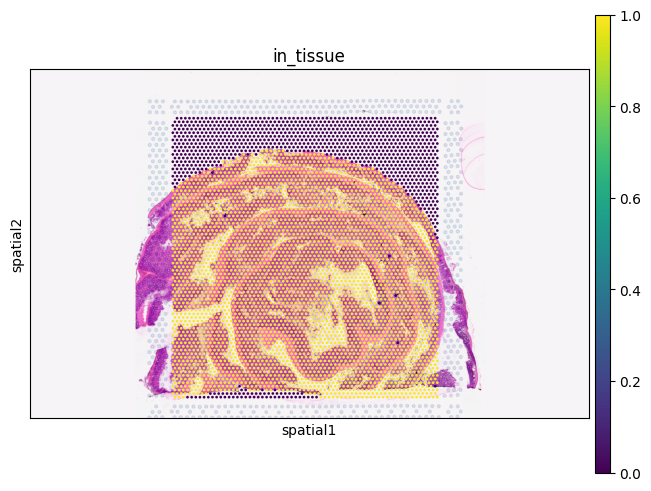

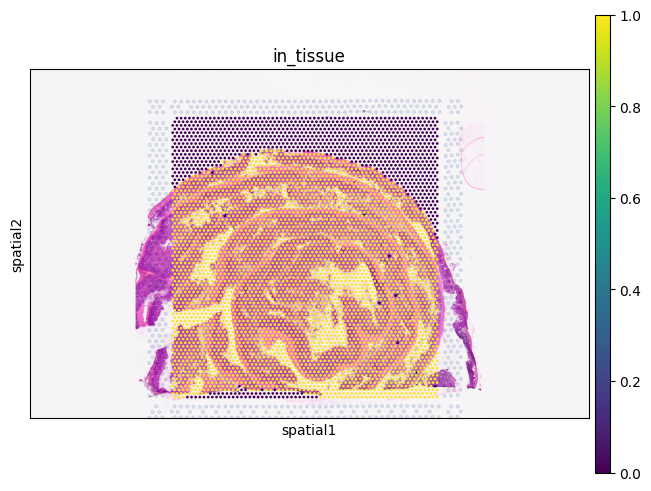

In [89]:
#QA by plotting with the hires image
sq.pl.spatial_scatter(
    adata,
    library_id=library_id,
    color='in_tissue'
)

#same plot with fullres image, if present
if 'fullres' in adata.uns['spatial'][library_id]['images']:
    sq.pl.spatial_scatter(
        adata,
        library_id=library_id,
        color='in_tissue',
        img_res_key='fullres',
        scale_factor=1.0
        )

In [90]:
adata.uns

OrderedDict([('spatial',
              {'spaceranger200_count_46450_Mus_Tcel13290869_mm10-2020-A': {'images': {'hires': array([[[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
                 
                        [[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
                 
                        [[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
            

In [91]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,barcodes,cell_type_ontology_term_id,donor_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id
AAACAACGAATAGTTC-1,0.0,0.0,0.0,502,EFO:0010961,AAACAACGAATAGTTC,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAAGTATCTCCCA-1,1.0,50.0,50.0,5479,EFO:0010961,AAACAAGTATCTCCCA,CL:0009010,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAATCTACTAGCA-1,0.0,3.0,3.0,1137,EFO:0010961,AAACAATCTACTAGCA,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACACCAATAACTGC-1,1.0,59.0,59.0,7597,EFO:0010961,AAACACCAATAACTGC,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAGAGCGACTCCT-1,1.0,14.0,14.0,7610,EFO:0010961,AAACAGAGCGACTCCT,CL:0009010,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1.0,58.0,58.0,4820,EFO:0010961,TTGTTTCACATCCAGG,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTCATTAGTCTA-1,1.0,60.0,60.0,5928,EFO:0010961,TTGTTTCATTAGTCTA,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTCCATACAACT-1,1.0,45.0,45.0,5305,EFO:0010961,TTGTTTCCATACAACT,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTGTATTACACG-1,1.0,73.0,73.0,4907,EFO:0010961,TTGTTTGTATTACACG,CL:0000584,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155


In [92]:
del adata.obs['barcodes']

In [93]:
adata.obsm

AxisArrays with keys: spatial

In [94]:
#del adata.obsm['X_spatial']

In [95]:
adata.var

,feature_is_filtered
gene_ids,
ENSMUSG00000051951,False
ENSMUSG00000089699,False
ENSMUSG00000102331,False
ENSMUSG00000102343,False
ENSMUSG00000025900,False
...,...
ENSMUSG00000095523,False
ENSMUSG00000095475,False
ENSMUSG00000094855,False


In [96]:
adata.uns

OrderedDict([('spatial',
              {'spaceranger200_count_46450_Mus_Tcel13290869_mm10-2020-A': {'images': {'hires': array([[[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
                 
                        [[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
                 
                        [[246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246],
                         ...,
                         [246, 244, 246],
                         [246, 244, 246],
                         [246, 244, 246]],
            

In [97]:
# Check for non-finite values
invalid_values = adata.obs['array_row'].isna() | ~np.isfinite(adata.obs['array_row'])

# If there are any non-finite values, handle them
if invalid_values.any():
    # Option 1: Drop rows with non-finite values
    #adata = adata[~invalid_values]
    
    # Option 2: Fill missing values with a default (e.g., 0)
    adata.obs['array_row'].fillna(0, inplace=True)
    
# Convert to integer
adata.obs['array_row'] = adata.obs['array_row'].astype(int)

/tmp/ipykernel_51818/2085027531.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['array_row'].fillna(0, inplace=True)


In [98]:
# Check for non-finite values
invalid_values = adata.obs['array_col'].isna() | ~np.isfinite(adata.obs['array_col'])

# If there are any non-finite values, handle them
if invalid_values.any():
    # Option 1: Drop rows with non-finite values
    #adata = adata[~invalid_values]
    
    # Option 2: Fill missing values with a default (e.g., 0)
    adata.obs['array_col'].fillna(0, inplace=True)
    
# Convert to integer
adata.obs['array_col'] = adata.obs['array_col'].astype(int)

In [99]:
# Check for non-finite values
invalid_values = adata.obs['in_tissue'].isna() | ~np.isfinite(adata.obs['in_tissue'])

# If there are any non-finite values, handle them
if invalid_values.any():
    # Option 1: Drop rows with non-finite values
    #adata = adata[~invalid_values]
    
    # Option 2: Fill missing values with a default (e.g., 0)
     adata.obs['in_tissue'].fillna(0, inplace=True)
    
# Convert to integer
adata.obs['in_tissue'] = adata.obs['in_tissue'].astype(int)

In [100]:
adata.write('/lustre/scratch127/cellgen/cellgeni/cxgportal_sets/Treg_Gut_Niches/Final_objects/spatial_Tcel13290869.h5ad', compression = 'gzip')

In [101]:
adata.obs

,in_tissue,array_row,array_col,non_zero_counts,assay_ontology_term_id,cell_type_ontology_term_id,donor_id,development_stage_ontology_term_id,disease_ontology_term_id,is_primary_data,organism_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,suspension_type,tissue_type,tissue_ontology_term_id
AAACAACGAATAGTTC-1,0,0,0,502,EFO:0010961,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAAGTATCTCCCA-1,1,50,50,5479,EFO:0010961,CL:0009010,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAATCTACTAGCA-1,0,3,3,1137,EFO:0010961,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACACCAATAACTGC-1,1,59,59,7597,EFO:0010961,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
AAACAGAGCGACTCCT-1,1,14,14,7610,EFO:0010961,CL:0009010,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,58,4820,EFO:0010961,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTCATTAGTCTA-1,1,60,60,5928,EFO:0010961,unknown,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTCCATACAACT-1,1,45,45,5305,EFO:0010961,CL:0000034,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155
TTGTTTGTATTACACG-1,1,73,73,4907,EFO:0010961,CL:0000584,3B_Hh.anti_IL10r,MmusDv:0000061,PATO:0000461,True,NCBITaxon:10090,na,unknown,na,tissue,UBERON:0001155


In [102]:
required_columns = ['array_col', 'array_row', 'in_tissue']
missing_columns = [col for col in required_columns if col not in adata.obs.columns]

print("Missing columns:", missing_columns)


Missing columns: []


In [103]:
print("Data Types:")
print(adata.obs[['array_col', 'array_row', 'in_tissue']].dtypes)

print("\nMissing Values:")
print(adata.obs[['array_col', 'array_row', 'in_tissue']].isna().sum())

Data Types:
array_col    int64
array_row    int64
in_tissue    int64
dtype: object

Missing Values:
array_col    0
array_row    0
in_tissue    0
dtype: int64
